In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

### 0. 필요한 Data 가져오기

In [10]:
D_ITEMS = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/D_ITEMS.csv")
df = pd.read_csv("/home/watercar99/project/MIMIC-III/chartdata_24h.csv")
ards = pd.read_csv("/home/watercar99/project/MIMIC-III/ARDS.csv")

### 1. OI&OSI score 계산 위해 필요한 column 추출

#### 1-1. Mean Airway Pressure

In [11]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('MEAN AIR',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('MAP', na=False) | D_ITEMS['ABBREVIATION'].str.contains('MAP', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
139,1291,1199,HFO MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
140,1292,1200,High MAP Alarm,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
141,1293,1201,Low MAP alarm,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
667,404,438,MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1443,624,672,TCPCV-MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1577,758,3067,FEM MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2330,1784,5680,RADIAL MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2453,1907,5804,sheath MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3105,3474,2309,FEM ALINE MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3127,3496,2353,R FEM MAP,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [12]:
# item_list = [444, 227023, 224322]
item_list = [444]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/mean_airway_pressure.csv", index=False)

전체 N 수: 2439
전체 평균 (Overall Mean): 11.078146229566384
전체 표준편차 (Overall Standard Deviation): 3.6831543310681414


,SUBJECT_ID,HADM_ID,VALUE
0,101,175533,13.450000
1,111,192123,10.666667
2,141,168006,13.100000
3,148,199488,7.000000
4,170,175350,9.571429
...,...,...,...
2434,32763,160695,10.714286
2435,32779,133757,19.125000
2436,32781,142684,12.500000
2437,32786,165351,12.133333


#### 1-2. SpO2

In [13]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('SpO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('SpO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('SpO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1418,599,646,SpO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2469,1923,5820,SpO2 Alarm [Low],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4804,4998,8554,SpO2 Alarm [High],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
5080,4343,6719,SpO2-L,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
11926,14442,226253,SpO2 Desat Limit,SpO2 Desat Limit,metavision,chartevents,Alarms,%,Numeric,NaN
12355,12746,220277,O2 saturation pulseoxymetry,SpO2,metavision,chartevents,Respiratory,%,Numeric,NaN
12374,12765,223769,O2 Saturation Pulseoxymetry Alarm - High,SpO2 Alarm - High,metavision,chartevents,Alarms,%,Numeric,NaN
12375,12766,223770,O2 Saturation Pulseoxymetry Alarm - Low,SpO2 Alarm - Low,metavision,chartevents,Alarms,%,Numeric,NaN


In [14]:
# item_list = [646, 5820, 8554, 226253, 220277, 223769, 223770]
item_list = [646, 5820, 8554, 220277]
# item_list = [646]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/SpO2.csv", index=False)

전체 N 수: 5738
전체 평균 (Overall Mean): 96.01652853366286
전체 표준편차 (Overall Standard Deviation): 5.9565577362568645


,SUBJECT_ID,HADM_ID,VALUE
0,91,121205,98.700000
1,101,175533,97.483871
2,111,192123,97.400000
3,141,168006,87.269231
4,148,199488,93.086957
...,...,...,...
5733,99881,172327,95.961538
5734,99899,188409,99.125000
5735,99912,189380,96.464286
5736,99939,159023,99.148148


#### 1-3. PaO2

In [15]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('PaO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('PaO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('PaO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1518,699,779,Arterial PaO2,NaN,carevue,chartevents,ABG,NaN,NaN,NaN


In [16]:
# PaO2
# item_list = [779(Arterial PaO2), 490(PAO2 - 779보다 분포 큼 + 1명 추가됨 + 사용할 경우 mean, SD 2씩 증가)] -> 그래서 779만 사용
item_list = [779]

# PO2
# item_list = [227516, 220224(227516보다 분포 큼), 226063]
# item_list = [227039]

# PaO2&PO2
# item_list = [779, 227516]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/PaO2.csv", index=False)

전체 N 수: 2675
전체 평균 (Overall Mean): 138.83110043225793
전체 표준편차 (Overall Standard Deviation): 60.81940409471366


,SUBJECT_ID,HADM_ID,VALUE
0,91,121205,131.000000
1,101,175533,115.428571
2,111,192123,153.800000
3,141,168006,129.857143
4,148,199488,96.000000
...,...,...,...
2670,32779,133757,203.000000
2671,32781,142684,245.800000
2672,32786,165351,143.500000
2673,32800,179038,193.400000


#### 1-4. FiO2

In [17]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('FiO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('FIO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('FIO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
45,1197,1040,BIpap FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
146,1298,1206,HFO FIO2:,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
449,186,185,FIO2 Alarm-High,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
450,187,186,FIO2 Alarm-Low,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1838,1019,3420,FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1839,1020,3421,FIO2 Alarm [Low],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1840,1021,3422,FIO2 [Meas],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3243,3612,2518,HFO- FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4506,4700,7570,FIO2 SET,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4774,4968,8517,FIO2 Alarm [High],NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [18]:
item_list = [189, 190] # 1 이하인 FiO2 칼럼 모음 - 아마 100 곱해서 사용해야할듯
# item_list = [185, 186, 727, 223835 , 226754, 227010]# 1이상인 FiO2 칼럼 모음
# item_list = [185, 186, 727, 223835]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/FiO2.csv", index=False)

전체 N 수: 2646
전체 평균 (Overall Mean): 0.5685677078229585
전체 표준편차 (Overall Standard Deviation): 0.1586582433460205


,SUBJECT_ID,HADM_ID,VALUE
0,101,175533,0.566667
1,111,192123,0.518182
2,141,168006,0.540000
3,148,199488,1.000000
4,170,175350,0.411111
...,...,...,...
2641,32779,133757,0.412500
2642,32781,142684,0.590000
2643,32786,165351,0.785714
2644,32800,179038,0.600000


### 2. calculate OI&OSI

In [19]:
ap = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/mean_airway_pressure.csv")
spo2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/SpO2.csv")
pao2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/PaO2.csv")
fio2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/FiO2.csv")

In [20]:
data = pd.merge(ap, spo2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE_x':'MAP', 'VALUE_y':'SpO2'}, inplace=True)

data = pd.merge(data, pao2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE':'PaO2'}, inplace=True)

data = pd.merge(data, fio2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE':'FiO2'}, inplace=True)

data = pd.merge(data, ards, on=['SUBJECT_ID', 'HADM_ID'])

# y column 제외한 data에 0이 있는 경우 drop 
data = data[(data['MAP'] != 0) & (data['SpO2'] != 0) & (data['PaO2'] != 0) & (data['FiO2'] != 0)]
data

,SUBJECT_ID,HADM_ID,MAP,SpO2,PaO2,FiO2,y
0,101,175533,13.450000,97.483871,115.428571,0.566667,1
1,111,192123,10.666667,97.400000,153.800000,0.518182,0
2,141,168006,13.100000,87.269231,129.857143,0.540000,1
3,148,199488,7.000000,93.086957,96.000000,1.000000,0
4,170,175350,9.571429,96.816092,183.000000,0.411111,0
...,...,...,...,...,...,...,...
2287,32763,160695,10.714286,96.481481,168.000000,0.475000,1
2288,32779,133757,19.125000,95.813725,203.000000,0.412500,1
2289,32781,142684,12.500000,96.494624,245.800000,0.590000,0
2290,32786,165351,12.133333,95.152174,143.500000,0.785714,0


In [21]:
def calculate_OI(df):
    data['OI'] = data['FiO2'] * 100 * data['MAP'] / data['PaO2']
    return data

def calculate_OSI(df):
    data['OSI'] = data['FiO2'] * 100 * data['MAP'] / data['SpO2']    
    return data

data = calculate_OI(data)
data = calculate_OSI(data)
data

,SUBJECT_ID,HADM_ID,MAP,SpO2,PaO2,FiO2,y,OI,OSI
0,101,175533,13.450000,97.483871,115.428571,0.566667,1,6.602929,7.818387
1,111,192123,10.666667,97.400000,153.800000,0.518182,0,3.593805,5.674818
2,141,168006,13.100000,87.269231,129.857143,0.540000,1,5.447525,8.105950
3,148,199488,7.000000,93.086957,96.000000,1.000000,0,7.291667,7.519851
4,170,175350,9.571429,96.816092,183.000000,0.411111,0,2.150230,4.064325
...,...,...,...,...,...,...,...,...,...
2287,32763,160695,10.714286,96.481481,168.000000,0.475000,1,3.029337,5.274883
2288,32779,133757,19.125000,95.813725,203.000000,0.412500,1,3.886238,8.233750
2289,32781,142684,12.500000,96.494624,245.800000,0.590000,0,3.000407,7.642913
2290,32786,165351,12.133333,95.152174,143.500000,0.785714,0,6.643438,10.019039


In [22]:
# data.to_csv("~/project/MIMIC-III/Data/OI&OSI/new_OI&OSI(down).csv", index=False)

In [23]:
# OI, OSI 칼럼의 mean, max, min, SD 계산
print("ards 데이터:", len(ards))
print("OI&OSI 데이터:", len(data))
print("")
print("OI&OSI 데이터의 y label 비율:")
print(data['y'].value_counts())
print("")
print("OI 열의 평균:", data["OI"].mean())
print("OI 열의 최소:", data["OI"].min())
print("OI 열의 최대:", data["OI"].max())
print("OI 열의 표준편차:", data["OI"].std())
print("")
print("OSI 열의 평균:", data["OSI"].mean())
print("OSI 열의 최소:", data["OSI"].min())
print("OSI 열의 최대:", data["OSI"].max())
print("OSI 열의 표준편차:", data["OSI"].std())

ards 데이터: 5888
OI&OSI 데이터: 2282

OI&OSI 데이터의 y label 비율:
0    1677
1     605
Name: y, dtype: int64

OI 열의 평균: 5.513696449829923
OI 열의 최소: 0.556291400728373
OI 열의 최대: 47.82859101052563
OI 열의 표준편차: 4.516694268296947

OSI 열의 평균: 6.926805115286909
OSI 열의 최소: 0.8312384906837205
OSI 열의 최대: 42.652329749103934
OSI 열의 표준편차: 3.8966118772757556


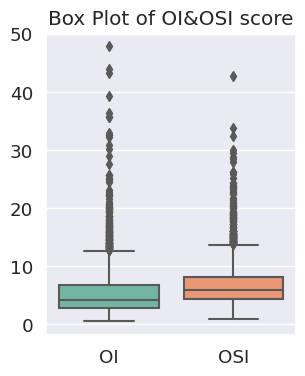

In [24]:
plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=data[["OI", "OSI"]], palette="Set2")
plt.title("Box Plot of OI&OSI score")

plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# severity level of OI, OSI
def assign_severity(row):
    if row['OI'] >= 16 or row['OSI'] >= 12.3:
        return 'severe'
    elif 8 <= row['OI'] < 16 or 7.5 <= row['OSI'] < 12.3:
        return 'moderate'
    elif 4 <= row['OI'] < 8 or 5 <= row['OSI'] < 7.5:
        return 'mild'
    else:
        return 'unknown'

# data에 severity column 추가
data['severity'] = data.apply(assign_severity, axis=1)

# severity level별 y column이 1인 비율 계산 (inhospital mortality rate) + level 별 개수 count
severity_counts = data.groupby('severity')['y'].mean().round(4) * 100
severity_counts = pd.concat([severity_counts, data['severity'].value_counts()], axis=1)
severity_counts.columns = ['mortality rate', 'count']

severity_counts

,mortality rate,count
mild,26.07,863
moderate,31.79,541
severe,41.24,194
unknown,18.71,684


### 3. OI&OSI cut

In [3]:
data = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/new_OI&OSI(down).csv")
# data = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/new_OI&OSI(up).csv")
data = data[["SUBJECT_ID", "HADM_ID", "OI", "OSI", "y"]]
data

,SUBJECT_ID,HADM_ID,OI,OSI,y
0,101,175533,6.602929,7.818387,1
1,111,192123,3.593805,5.674818,0
2,141,168006,5.447525,8.105950,1
3,148,199488,7.291667,7.519851,0
4,170,175350,2.150230,4.064325,0
...,...,...,...,...,...
2277,32763,160695,3.029337,5.274883,1
2278,32779,133757,3.886238,8.233750,1
2279,32781,142684,3.000407,7.642913,0
2280,32786,165351,6.643438,10.019039,0


#### 3-1. OI cut

In [26]:
# OI 값을 기준으로 리스트들을 함께 정렬
sorted_lists = sorted(zip(data['OI'], data['y']))
sorted_OI, sorted_y = zip(*sorted_lists)

# 컷 값을 선택하는 부분
best_cut = None
best_f1 = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_auroc = 0  # AUROC 초기화

for i in range(1, len(sorted_OI)):
    y_left = sorted_y[:i]
    y_right = sorted_y[i:]
    
    tp = y_left.count(1) + y_right.count(1)
    fp = y_left.count(0) + y_right.count(1)
    fn = y_left.count(1) + y_right.count(0)
    tn = y_left.count(0) + y_right.count(0)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    probas = [0] * len(sorted_y)
    probas[i:] = [1] * len(y_right)
    auroc = roc_auc_score(sorted_y, probas)
    
    if f1 > best_f1:
        best_f1 = f1
        best_cut = (sorted_OI[i-1] + sorted_OI[i]) / 2  # 인접한 값의 중간 지점 선택
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_auroc = auroc

print("OI Best cut:", best_cut)

print("Best Accuracy:", best_accuracy)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
print("Best F1 Score:", best_f1)
print("Best AUROC:", best_auroc)


OI Best cut: 1.2148313300343978
Best Accuracy: 0.5
Best Precision: 0.4879032258064516
Best Recall: 0.26865008880994673
Best F1 Score: 0.34650630011454764
Best AUROC: 0.5073596593681161


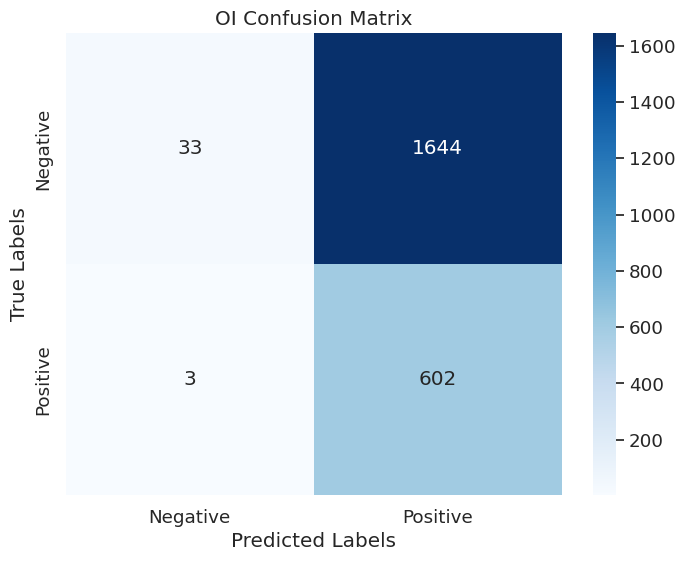

In [27]:
# best_cut 값을 사용하여 y_pred 생성
y_pred = [0 if value <= best_cut else 1 for value in data['OI']]

conf_matrix = confusion_matrix(data['y'], y_pred)

labels = ["Negative", "Positive"]

# 혼동 행렬을 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("OI Confusion Matrix")
plt.show()

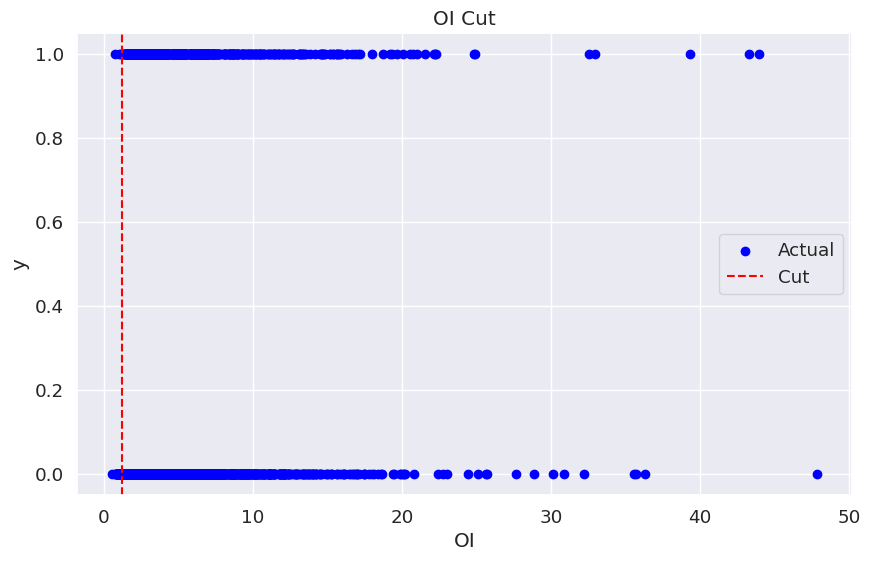

In [28]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(sorted_OI, sorted_y, color='blue', label='Actual')
plt.axvline(x=best_cut, color='red', linestyle='--', label='Cut')
plt.xlabel('OI')
plt.ylabel('y')
plt.title('OI Cut')
plt.legend()
plt.show()

In [29]:
data_1 = data[data['y']==1]['OI']
data_0 = data[data['y']==0]['OI']

print(data_1.median(),data_0.median())

4.834976105137395 4.000000059604645


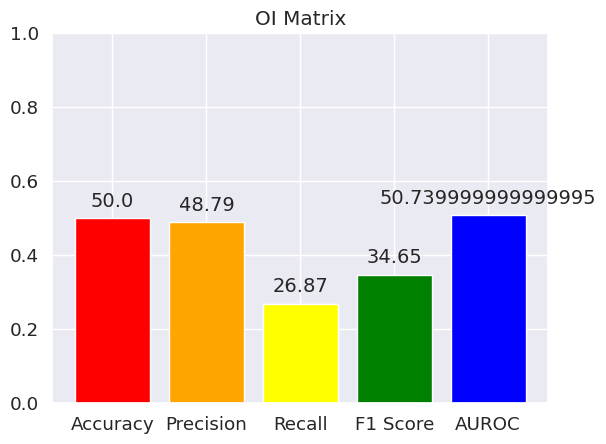

In [30]:
# 그래프 그리기
labels = ['Accuracy','Precision', 'Recall','F1 Score', "AUROC"]
values = [best_accuracy, best_precision, best_recall, best_f1, best_auroc]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['red', 'orange','yellow','green', 'blue'])
# plt.ylabel('Value')
plt.title('OI Matrix')
plt.ylim(0, 1) 

# 막대 내부에 큰 글꼴 크기로 수치 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4)*100, ha='center', va='bottom', fontsize=14)  # fontsize 조정

plt.show()

In [31]:
# y_pred 리스트 내의 값을 카운트
value_counts1 = Counter(data['y'])
value_counts2 = Counter(y_pred)

print("Value Counts:", value_counts1)
print("Value Counts:", value_counts2)

Value Counts: Counter({0: 1677, 1: 605})
Value Counts: Counter({1: 2246, 0: 36})


#### 3-2. OSI cut

In [4]:
# OSI 값을 기준으로 리스트들을 함께 정렬
sorted_lists = sorted(zip(data['OSI'], data['y']))
sorted_OSI, sorted_y = zip(*sorted_lists)

# 컷 값을 선택하는 부분
best_cut = None
best_f1 = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_auroc = 0 

for i in range(1, len(sorted_OSI)):
    y_left = sorted_y[:i]
    y_right = sorted_y[i:]
    
    tp = y_left.count(1) + y_right.count(1)
    fp = y_left.count(0) + y_right.count(1)
    fn = y_left.count(1) + y_right.count(0)
    tn = y_left.count(0) + y_right.count(0)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    probas = [0] * len(sorted_y)
    probas[i:] = [1] * len(y_right)
    auroc = roc_auc_score(sorted_y, probas)
    
    if f1 > best_f1:
        best_f1 = f1
        best_cut = (sorted_OSI[i-1] + sorted_OSI[i]) / 2  # 인접한 값의 중간 지점 선택
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_auroc = auroc

print("OSI Best cut:", best_cut)
print("Best Accuracy:", best_accuracy)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
print("Best F1 Score:", best_f1)
print("Best AUROC:", best_auroc)

OSI Best cut: 2.6088479345886944
Best Accuracy: 0.5
Best Precision: 0.4879032258064516
Best Recall: 0.26865008880994673
Best F1 Score: 0.34650630011454764
Best AUROC: 0.5063030697280169


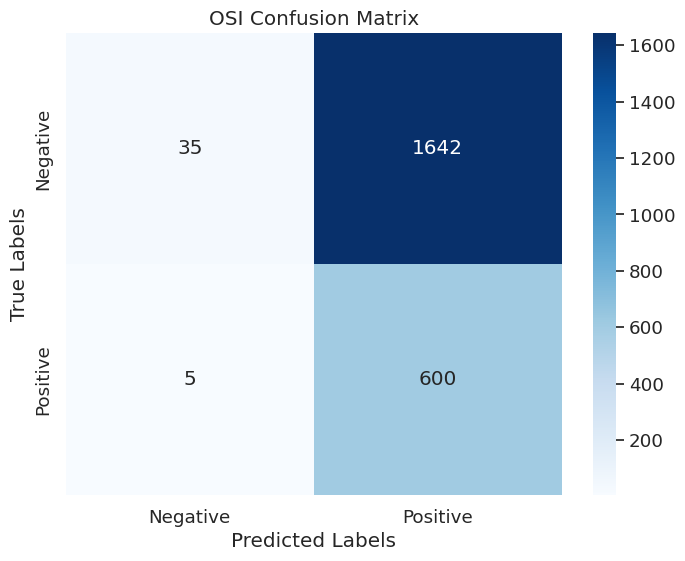

In [5]:
# best_cut 값을 사용하여 y_pred 생성
y_pred = [0 if value <= best_cut else 1 for value in data['OSI']]

conf_matrix = confusion_matrix(data['y'], y_pred)

labels = ["Negative", "Positive"]

# 혼동 행렬을 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("OSI Confusion Matrix")
plt.show()

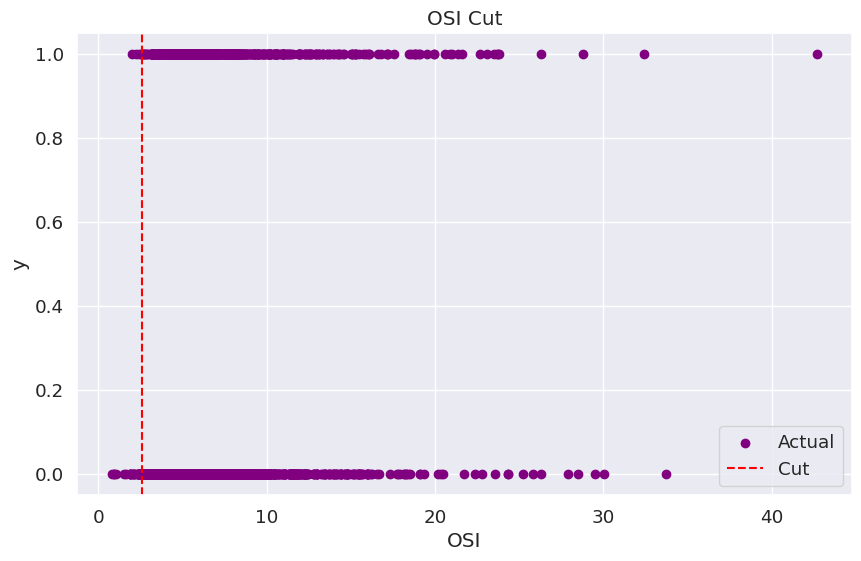

In [6]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(sorted_OSI, sorted_y, color='purple', label='Actual')
plt.axvline(x=best_cut, color='red', linestyle='--', label='Cut')
plt.xlabel('OSI')
plt.ylabel('y')
plt.title('OSI Cut')
plt.legend()
plt.show()

In [7]:
data_1 = data[data['y']==1]['OSI']
data_0 = data[data['y']==0]['OSI']

print(data_1.median(),data_0.median())

6.64059983448057 5.6584003131538685


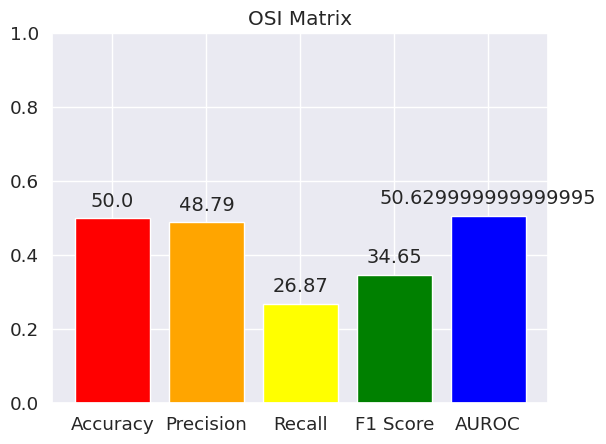

In [8]:
# 그래프 그리기
labels = ['Accuracy','Precision', 'Recall','F1 Score', "AUROC"]
values = [best_accuracy, best_precision, best_recall, best_f1, best_auroc]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['red', 'orange','yellow','green', 'blue'])
# plt.ylabel('Value')
plt.title('OSI Matrix')
plt.ylim(0, 1) 

# 막대 내부에 큰 글꼴 크기로 수치 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4)*100, ha='center', va='bottom', fontsize=14)  # fontsize 조정

plt.show()

In [9]:
# y_pred 리스트 내의 값을 카운트
value_counts1 = Counter(data['y'])
value_counts2 = Counter(y_pred)

print("Value Counts:", value_counts1)
print("Value Counts:", value_counts2)

Value Counts: Counter({0: 1677, 1: 605})
Value Counts: Counter({1: 2242, 0: 40})
